# Master Cluster Analysis
Alloy F, R33_31671
Master File with the main procedure to be applied to all reconstructions with clusters

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import clustering_corrections as cc
import posgenpy as pgp
import os
import subprocess
from time import perf_counter
# from sklearn.neighbors import KDTree
import plotly.express as px
import plotly.graph_objects as go

# PosgenPy 
Here you have to optimise $Order (knn)$ and then $d_{max}$ and then $N_{min}$ to find the optimal cluster search parameters


In [2]:
######################### INPUT REQUIRED #########################
sample_name = 'ALM_R17_Mag2.0'
sample_group = "ALM_R17"
output_folder = f"/mnt/d/OKMC_model_data/{sample_name}_folder/" # put "/" at the end
posgen_folder = "/home/pklups/apttools-posgen-code/" # put "/" at the end
pos_file_path= f"{output_folder}/{sample_name}.POS" 
range_file_path= f"/mnt/d/OKMC_model_data/OKMC_range_file.RRNG" 

# clustering settings
random_runs = 10
confidence_threshold = 0.95 # * 100 %
detector_efficiency=0.50 # 0.52 if LEAP5000+ or 0.37 if LEAP3000
atomic_density_per_nm3=85.49 # 85.49 if BCC-iron

dtd_location = "/home/pklups/apttools-posgen-code/"

# read the ions available in the range file and spit them out
ranged_ions = []
for row in pd.read_csv(range_file_path)['[Ions]']:
    if "Ion" in row:
        ranged_ions.append(row.split(sep='=')[-1])
print(ranged_ions)

['Fe', 'Ni', 'Mn', 'Si', 'P', 'Cu']


In [3]:
# select ions
core_ions = ["Ni", "Mn", "Si"]
bulk_ions = ['Fe', 'P', 'Cu']

# check if the ions selected are available in the range file
for ion in (core_ions + bulk_ions):
    if ion not in ranged_ions:
        print(ion, "not found in the range file")

In [57]:
######################### INPUT REQUIRED #########################

# add or remove values in this list
# you can also create the same list for different parameter
order_values = [3, 4, 5, 6, 7, 8]
d_max = 0.60 # select dmax


In [58]:
xml_files = []
output_basename="{sample_name}_dmax{d_max}_order_{order}"

for i, param_value in enumerate(order_values):
    thisName = output_basename.format(d_max=d_max, order=param_value, sample_name=sample_name.replace(" ", "_"))
    xml_output = pgp.write_xml_with_relabelling(xmlFileName=thisName,
                                                posFile=pos_file_path,
                                                rangeFile=range_file_path,
                                                coreIons=core_ions,
                                                bulkIons=bulk_ions,
                                                relabelled_runs=random_runs,
                                                destination_folder=output_folder,
                                                nminV=2,
                                                dmax=d_max,
                                                dtd_file_location=dtd_location,
                                                dclassify=d_max,
                                                knn=param_value
                                                
                                  )
    output_file = output_folder + str(thisName) + ".xml"
    xml_files.append(output_file)

In [59]:
# check if the xml files have been created
for x in xml_files:
    print(x)

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_3.xml
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_4.xml
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_5.xml
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_7.xml
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_8.xml


In [7]:
# run the cluster analyses
current_directory = os.getcwd()
os.chdir(posgen_folder)
print(os.getcwd())

tic = perf_counter()
for i, xml_file in enumerate(xml_files):
    posgen_output = subprocess.call(["./posgen", xml_file])
    toc = perf_counter()
    time_for_file = pgp.seconds_to_hhmmss((toc-tic))
    print(f"File: {i+1}/{len(xml_files)} analysed. It took {time_for_file}.")
    tic = perf_counter()
    
os.chdir(current_directory)
print(os.getcwd())

/home/pklups/apttools-posgen-code
File: 1/6 analysed. It took 0h 1m 18s.
File: 2/6 analysed. It took 0h 0m 48s.
File: 3/6 analysed. It took 0h 0m 34s.
File: 4/6 analysed. It took 0h 0m 55s.
File: 5/6 analysed. It took 0h 0m 30s.
File: 6/6 analysed. It took 0h 0m 35s.
/mnt/c/Users/Peter/OneDrive - Nexus365/Projects/RR/OKMC


In [19]:
# correct the results straight away
elements_to_exclude = ["Fe"]
# decompose the clusters
for xml_file in (xml_files):

    for i in range(random_runs+1):

        if i == 0:
            i_name = ''
        elif i > 0:
            i_name = f"_random_{i}"
        else:
            print("Error")

        try:
            
            # open both files
            cluster_stats_file_path = xml_file.replace(".xml", f"{i_name}_cluster-stats.txt")
            unclustered_stats_file_path = xml_file.replace(".xml", f"{i_name}_unclustered-stats.txt")
            csdf = pd.read_csv(cluster_stats_file_path, sep="\t")
            ucsdf = pd.read_csv(unclustered_stats_file_path, sep="\t")
            
            # decompose
            # csdf = cc.decompose_cluster_stats(csdf)
            # ucsdf = cc.decompose_cluster_stats(ucsdf)

            # deconvolute Fm peak
            # csdf = cc.deconvolute_Fm_clusters(csdf)
            # ucsdf = cc.deconvolute_Fm_clusters(ucsdf)

            # exclude Fe from cluster size calculations
            csdf['Cluster Size without Fe'] = pgp.calculate_cluster_size(csdf, core_ions, bulk_ions, elements_to_exclude)
            csdf['Cluster Size'] = pgp.calculate_cluster_size(csdf, core_ions, bulk_ions, [])
            ucsdf['Cluster Size'] = pgp.calculate_cluster_size(ucsdf, core_ions, bulk_ions, [])

            # save them as csv files
            csdf.to_csv(cluster_stats_file_path, sep='\t', index=False)
            ucsdf.to_csv(unclustered_stats_file_path, sep='\t', index=False)
       
        except:
            print("Empty data in:", xml_file, i)
    
    print(xml_file, "corrected")
    

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_3.xml corrected
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_4.xml corrected
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_5.xml corrected
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml corrected
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_7.xml corrected
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_8.xml corrected


### Plotting threshold value
$(N_{real} - N_{rand})/N_{real}$

([<matplotlib.axis.XTick at 0x7fea12674a20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

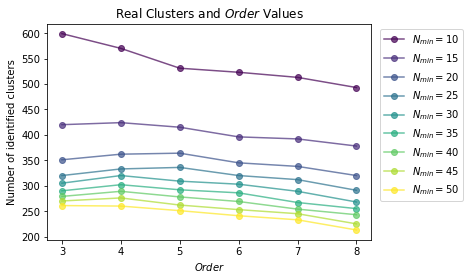

In [20]:
n_min_values = list(range(10, 51, 5))
pgp.plot_real_clusters_across_swept_param(
    swept_parameters=order_values,
    swept_parameter_name="$Order$",
    random_runs=random_runs,
    xml_files=xml_files,
    n_min_values=n_min_values
)

# plt.yscale("log")
# plt.ylim(0.0, 100)
# plt.xlim(0, 11)
plt.xticks(order_values)

In [10]:
# that's wrong
# n_min_values = list(range(2, 21, 2))

# pgp.plot_real_cluster_ratio_across_swept_param(
#     swept_parameters=order_values,
#     swept_parameter_name="$Order$",
#     random_runs=random_runs,
#     xml_files=xml_files,
#     n_min_values=n_min_values,
#     threshold=confidence_threshold
# )

# # plt.ylim(0.0, 1.02)
# plt.xticks(order_values)

## Find optimal N_min

Find the smallest $N_{min}$ value for each file that satisfies given threshold of real clusters. Default value = 95%

In [60]:
optimal_n_min_values_order, optimised_real_clusters_order, optimised_random_clusters_order = pgp.optimise_n_min(
    xml_files=xml_files,
    random_runs=random_runs,
    confidence_threshold=confidence_threshold
)

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_3.xml | Nmin:267 | TPR: 0.95	(real:141 | random:7)
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_4.xml | Nmin:100 | TPR: 0.95	(real:244 | random:12)
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_5.xml | Nmin:40 | TPR: 0.95	(real:327 | random:16)
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml | Nmin:26 | TPR: 0.95	(real:349 | random:16)
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_7.xml | Nmin:19 | TPR: 0.95	(real:393 | random:18)
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_8.xml | Nmin:11 | TPR: 0.96	(real:508 | random:20)


Text(0.5, 1.0, 'Cluster Analysis Parameters for ALM_R17_Mag2.0')

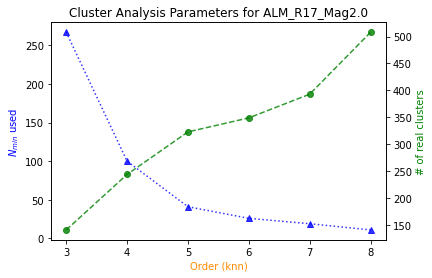

In [22]:
# plot the real clusters after optimisation to select the max point
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(order_values, optimal_n_min_values_order, 'b^:', alpha=0.8)
ax2.plot(order_values, optimised_real_clusters_order, 'go--', alpha=0.8)

ax1.set_xlabel('Order (knn)', color='darkorange')
ax2.set_ylabel('# of real clusters', color='g')
ax1.set_ylabel('$N_{min}$ used', color='b')
# plt.legend(loc='upper right')
plt.title(f"Cluster Analysis Parameters for {sample_name}")
# plt.savefig('optimising_by_max_real_clusters_order_dmax05.jpg', dpi=150)

## Cluster kNN Distance Distribution vs Cluster Size
Let's plot cluster sizes as well as cluster kNN distance distribution to investigate how our parameters affect the clusters that are very close to each other. It's expected to see some of the clusters wrongly split into two or, vice versa, some close agglomerations being joined together and forming mega clusters. These can be seen at the very extremes of these graphs.

In [61]:
# prepare the data
swept_parameter_name = "Order"
df = cc.prepare_df_for_cluster_distr(xml_files, order_values, "Order", include_random=True, n_mins=optimal_n_min_values_order)
cols_to_plot = [col for col in df.columns if col not in ranged_ions]

In [62]:
# plot distributions of cluster sizes
fig = px.violin(df, y="Cluster Size", x="Order", color="Type", box=False, points="all",
          hover_data=cols_to_plot, color_discrete_map={'real':'#063970', 'random':'#e28743'})

fig.update_layout(
    title_text=f"Size Distributions and Order parameter<br>in {sample_name}",
    xaxis_title='Order',
    yaxis_title="Cluster Size [ions]",
    violingap=0, 
    violinmode='overlay', 
    template='simple_white',
    height=500, 
    width=800
    )

fig.update_yaxes(
    rangemode='nonnegative',
)
fig.update_traces(box_visible=True, meanline_visible=True)
fig.show()

In [25]:
# plot distribution of distances to closest clusters
fig = px.violin(df[df['Type']=='real'], y="Closest Cluster Distance", x="Order", box=False, points="all",
          hover_data=cols_to_plot, 
          color='Type',
          color_discrete_map={'real':'#700539', 'random':'#e28743'}
    )

fig.update_layout(
    title_text=f"kNN Distance Distributions and Order parameter<br>in {sample_name}",
    xaxis_title='Order',
    yaxis_title="kNN Distance [nm]",
    violingap=0, 
    violinmode='overlay', 
    template='simple_white',
    height=500, 
    width=800
    )

fig.update_yaxes(
    rangemode='nonnegative',
)

fig.update_traces(box_visible=True, meanline_visible=True)

fig.show()

In [63]:
# plot selected cluster(s) 
test_df = cc.show_clusters_in_pos(
    clusters_to_plot=[715], 
    xml_files=xml_files,
    swept_param_values=order_values,
    chosen_param_value=6,
    range_file_path=range_file_path
)


/home/pklups/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Compare cluster shapes 

...across all param clusterID.pos files

In [64]:
# see selected cluster(s) across all param values in one scattered 3d graph
fig = cc.compare_selected_clusters_across_param(
    xml_files=xml_files,
    swept_param_values=order_values,
    swept_param_name='Order',
    chosen_param_value=6,
    selected_clusters=[715]
)
fig.show()

## Plotting cluster composition

In [27]:
# use same colours as in the range file
element_colours = cc.get_element_colours_from_range_file(range_file_path)
# and remove Fm from the list of core ions
# core_ions = ['Ni', 'Mn', 'Si']

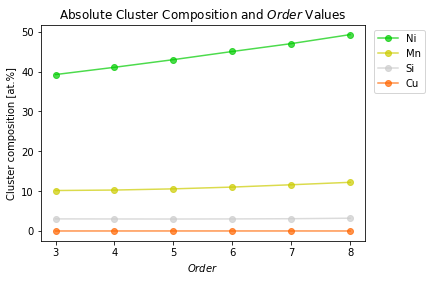

In [28]:
# retrieve the data needed from the cluster stats files for the composition plots
pgp.plot_cluster_composition_across_swept_param_absolute(
    swept_parameters=order_values,
    core_ions=['Ni', 'Mn', 'Si', 'Cu'],
    xml_files=xml_files,
    n_min_values_for_swept_parameters=optimal_n_min_values_order,
    swept_parameter_name="$Order$",
    exclude_ions=[],
    ion_colors=element_colours
)

# plt.savefig('composition_vs_order_dmax05.jpg')

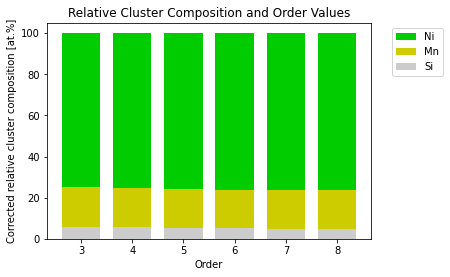

In [29]:
pgp.plot_cluster_composition_across_swept_param_relative(
    swept_parameters=order_values,
    core_ions=core_ions,
    xml_files=xml_files,
    n_min_values_for_swept_parameters=optimal_n_min_values_order,
    swept_parameter_name="Order",
    exclude_ions=None,
    ion_colors=element_colours
)

# $d_{max}$ sweep at specified Order

In [76]:
######################### INPUT REQUIRED #########################

# add or remove values in this list
# you can also create the same list for different parameter
# d_max_values = [1, 2, 3, 4]
d_max_values = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
d_max_values = [0.55, 0.575, 0.6, 0.625, 0.65]
d_max_values = [0.55, 0.6, 0.625, 0.65, 0.675, 0.7]
d_max_values = [0.6]
order = 6 # select dmax, hopefully the graphs above can help
random_runs = 30

In [77]:
xml_files = []
# output_basename="R33_31691_D_dmax{d_max}_order_{order}"
output_basename="{sample_name}_dmax{d_max}_order_{order}"

for i, d_max in enumerate(d_max_values):
    thisName = output_basename.format(order=order, d_max=d_max, sample_name=sample_name.replace(" ", "_"))
    xml_output = pgp.write_xml_with_relabelling(xmlFileName=thisName,
                                                posFile=pos_file_path,
                                                rangeFile=range_file_path,
                                                coreIons=core_ions,
                                                bulkIons=bulk_ions,
                                                relabelled_runs=random_runs,
                                                destination_folder=output_folder,
                                                nminV=2,
                                                dmax=d_max,
                                                dtd_file_location=dtd_location,
                                                dclassify=d_max,
                                                knn=order
                                                
                                  )
    output_file = output_folder + str(thisName) + ".xml"
    xml_files.append(output_file)

In [78]:
# check if the xml files have been created
for x in xml_files:
    print(x)

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml


In [79]:
current_directory = os.getcwd()
os.chdir(posgen_folder)
print(os.getcwd())

tic = perf_counter()
for i, xml_file in enumerate(xml_files):
    posgen_output = subprocess.call(["./posgen", xml_file])
    toc = perf_counter()
    time_for_file = pgp.seconds_to_hhmmss((toc-tic))
    print(f"File: {i+1}/{len(xml_files)} analysed. It took {time_for_file}.")
    tic = perf_counter()
    
os.chdir(current_directory)
print(os.getcwd())

/home/pklups/apttools-posgen-code
File: 1/1 analysed. It took 0h 1m 20s.
/mnt/c/Users/Peter/OneDrive - Nexus365/Projects/RR/OKMC


In [80]:
# correct the results straight away
elements_to_exclude = ["Fe"]
# decompose the clusters
for xml_file in (xml_files):

    for i in range(random_runs+1):

        if i == 0:
            i_name = ''
        elif i > 0:
            i_name = f"_random_{i}"
        else:
            print("Error")

        try:
            
            # open both files
            cluster_stats_file_path = xml_file.replace(".xml", f"{i_name}_cluster-stats.txt")
            unclustered_stats_file_path = xml_file.replace(".xml", f"{i_name}_unclustered-stats.txt")
            csdf = pd.read_csv(cluster_stats_file_path, sep="\t")
            ucsdf = pd.read_csv(unclustered_stats_file_path, sep="\t")
            
            # decompose
            # csdf = cc.decompose_cluster_stats(csdf)
            # ucsdf = cc.decompose_cluster_stats(ucsdf)

            # deconvolute Fm peak
            # csdf = cc.deconvolute_Fm_clusters(csdf)
            # ucsdf = cc.deconvolute_Fm_clusters(ucsdf)

            # exclude Fe from cluster size calculations
            csdf['Cluster Size without Fe'] = pgp.calculate_cluster_size(csdf, core_ions, bulk_ions, elements_to_exclude)
            csdf['Cluster Size'] = pgp.calculate_cluster_size(csdf, core_ions, bulk_ions, [])
            ucsdf['Cluster Size'] = pgp.calculate_cluster_size(ucsdf, core_ions, bulk_ions, [])

            # save them as csv files
            csdf.to_csv(cluster_stats_file_path, sep='\t', index=False)
            ucsdf.to_csv(unclustered_stats_file_path, sep='\t', index=False)
       
        except:
            print("Empty data in:", xml_file, i)
    
    print(xml_file, "corrected")
   

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml corrected


In [81]:
# n_min_values = list(range(2, 21, 2))

# pgp.plot_real_cluster_ratio_across_swept_param(
#     swept_parameters=d_max_values,
#     swept_parameter_name="$d_{max}$ [nm]",
#     random_runs=random_runs,
#     xml_files=xml_files,
#     n_min_values=n_min_values,
#     threshold=confidence_threshold
# )

# # plt.ylim(0.5, 1.05)

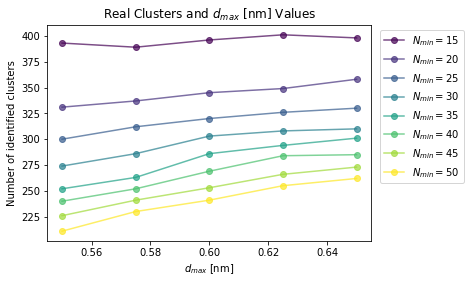

In [49]:
n_min_values = list(range(15, 51, 5))
pgp.plot_real_clusters_across_swept_param(
    swept_parameters=d_max_values,
    swept_parameter_name="$d_{max}$ [nm]",
    random_runs=random_runs,
    xml_files=xml_files,
    n_min_values=n_min_values,
)

# plt.yscale("log")

## Find optimal N_min

Find the smallest $N_{min}$ value for each file that satisfies given threshold of real clusters. Default value = 95%

In [82]:
optimal_n_min_values_dmax, optimised_real_clusters_dmax, optimised_random_clusters_dmax = pgp.optimise_n_min(
    xml_files=xml_files,
    random_runs=random_runs,
    confidence_threshold=confidence_threshold
)

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml | Nmin:25 | TPR: 0.96	(real:357 | random:15)


Text(0.5, 1.0, 'Cluster Analysis Parameters for Alloy D (RR33_31691)')

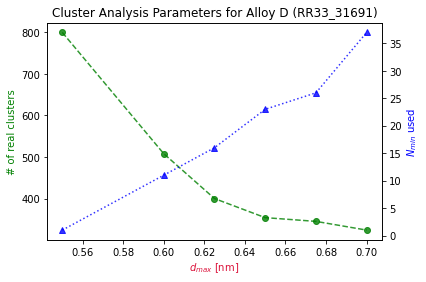

In [72]:
# plot the real clusters after optimisation to select the max point
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(d_max_values, optimal_n_min_values_dmax, 'b^:', alpha=0.8)
ax1.plot(d_max_values, optimised_real_clusters_dmax, 'go--', alpha=0.8)



ax1.set_xlabel('$d_{max}$ [nm]', color='crimson')
ax1.set_ylabel('# of real clusters', color='g')
ax2.set_ylabel('$N_{min}$ used', color='b')
# plt.legend(loc='upper right')
plt.title("Cluster Analysis Parameters for Alloy D (RR33_31691)")
# plt.savefig('optimising_by_max_real_clusters_dmax_order9.jpg', dpi=150)

## Cluster Size vs Distance Distribution


In [73]:
# prepare the data
swept_parameter_name = "dmax"
df = cc.prepare_df_for_cluster_distr(xml_files, d_max_values, "dmax", include_random=True, n_mins=optimal_n_min_values_dmax)

In [74]:
# plot distributions of cluster sizes

fig = px.violin(df, y="Cluster Size", x="dmax", color="Type", box=False, points="all",
          hover_data=df.columns, color_discrete_map={'real':'#063970', 'random':'#e28743'})

fig.update_layout(
    title_text=f"Size Distributions and d<sub>max</sub> parameter<br>in {sample_name}",
    xaxis_title='d<sub>max</sub>',
    yaxis_title="Cluster Size [ions]",
    violingap=0, 
    violinmode='overlay', 
    template='simple_white',
    height=500, 
    width=800
    )

fig.update_yaxes(
    rangemode='nonnegative',
)

fig.update_traces(box_visible=True, meanline_visible=True)
fig.show()

In [75]:
# plot distribution of distances to closest clusters
fig = px.violin(df[df['Type']=='real'], y="Closest Cluster Distance", x="dmax", box=False, points="all",
          hover_data=df.columns, 
          color='Type',
          color_discrete_map={'real':'#700539', 'random':'#e28743'}
    )

fig.update_layout(
    title_text=f"kNN Distance Distributions and d<sub>max</sub> parameter<br>in {sample_name}",
    xaxis_title='d<sub>max</sub>',
    yaxis_title="kNN Distance [nm]",
    violingap=0, 
    violinmode='overlay', 
    template='simple_white',
    height=500, 
    width=800
    )

fig.update_yaxes(
    rangemode='nonnegative',
)

fig.update_traces(box_visible=True, meanline_visible=True)

fig.show()

In [42]:
optimal_n_min_values_dmax

[6, 10, 14, 21, 40, 118, 499]

In [55]:
# plot selected cluster(s) 
_ = cc.show_clusters_in_pos(
    xml_files=xml_files,
    clusters_to_plot=[715], 
    swept_param_values=d_max_values,
    chosen_param_value=0.6,
    range_file_path=range_file_path
)


/home/pklups/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Compare cluster shapes 

...across all param clusterID.pos files

In [65]:
# see selected cluster(s) across all param values in one scattered 3d graph
fig = cc.compare_selected_clusters_across_param(
    xml_files=xml_files,
    swept_param_values=d_max_values,
    swept_param_name='dmax',
    chosen_param_value=0.6,
    selected_clusters=[321, 98]
)
fig.show()

## Plotting Cluster Composition

In [70]:
# get ion colours from range file (IVAS colours) for further plotting
element_colours = cc.get_element_colours_from_range_file(range_file_path)

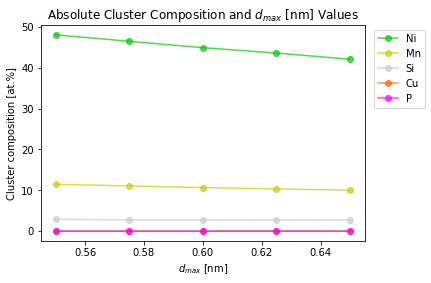

In [71]:
# retrieve the data needed from the cluster stats files for the composition plots
pgp.plot_cluster_composition_across_swept_param_absolute(
    swept_parameters=d_max_values,
    swept_parameter_name="$d_{max}$ [nm]",
    core_ions=core_ions+['Cu', 'P'],
    xml_files=xml_files,
    n_min_values_for_swept_parameters=optimal_n_min_values_dmax,
    exclude_ions=[],
    ion_colors=element_colours
)

# plt.savefig('composition_vs_dmax_order9.jpg', dpi=150)

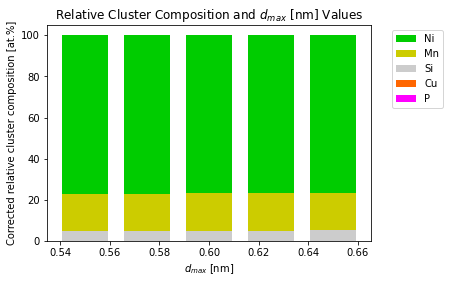

In [72]:
pgp.plot_cluster_composition_across_swept_param_relative(
    swept_parameters=d_max_values,
    swept_parameter_name="$d_{max}$ [nm]",
    core_ions=core_ions+['Cu', 'P'],
    xml_files=xml_files,
    n_min_values_for_swept_parameters=optimal_n_min_values_dmax,
    exclude_ions=None,
    ion_colors=element_colours
)

# Select the dataset
Select which parameters you want to use for further analysis

In [83]:
xml_files

['/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml']

In [84]:
optimal_n_min_values_dmax
# optimal_n_min_values_order

[25]

In [85]:
######################### OR FIND IT IN THE FOLDER #########################
selected_order = 6
selected_dmax = 0.60
n_min = 25

this_name = output_basename.format(d_max=selected_dmax, order=selected_order, sample_name=sample_name.replace(" ", "_"))
this_xml_file = output_folder+this_name+".xml"

xml_files_in_folder = [output_folder+xml_file for xml_file in os.listdir(output_folder) if xml_file.endswith(".xml")]

if this_xml_file in xml_files_in_folder:
    selected_xml_file = this_xml_file
    print("XML file with given parameters was found.")
    print(f"File: {selected_xml_file}")
    print("You can continue")
else:
    print(f"XML file with given parameters not found in {output_folder}")
    print("Are you sure you want to select these parameters?")
    print("You will have to run through them at least once")


XML file with given parameters was found.
File: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml
You can continue


# Correcting the datasets

In [86]:
# state the files
recon_name = selected_xml_file.split(sep='/')[-1].replace('.xml', '')
cluster_stats_file_path = selected_xml_file.replace(".xml", "_cluster-stats.txt")
unclustered_stats_file_path = selected_xml_file.replace(".xml", "_unclustered-stats.txt")
cluster_id_pos_file_path = selected_xml_file.replace(".xml", "_clusterID.pos")


In [87]:

# correct the files
corrected_files = cc.correct_cluster_files(
    pos_file_path=pos_file_path,
    rrng_file_path=range_file_path,
    cluster_stats_file_path=cluster_stats_file_path,
    unclustered_stats_file_path=unclustered_stats_file_path,
    clusterID_pos_file_path=cluster_id_pos_file_path,
    show_mass_spec=False,
    print_log=True,
    deconvolute_fm=False,
    nmin=n_min,
    xml_file=selected_xml_file
)

Opening pos and range files
Labeling ions
Opening cluster stats files
Decomposing cluster stats files
Performing KNN Cluster Distance analysis
Identifying and removing edge clusters
Preparing data for edge cluster removal
Calculating alphashape (might take a few seconds)
Alphashape calculated
Iterating through all clusters


100%|██████████| 1108/1108 [00:28<00:00, 39.49it/s]


Clusters smaller than nmin: 751 out of 1108
Edge clusters: 0 out of 357 (0.0%)
Done


In [88]:
cluster_stats_df = corrected_files["cluster_stats_df"]
cluster_pos = corrected_files['cluster_pos'].sort_values('Cluster ID')
# cluster_stats_df_nonedge = corrected_files["cluster_stats_df_post_nmin_post_edge"]
# cluster_stats_df_edge = corrected_files["edge_cluster_stats_df"]
unclustered_stats_df = corrected_files["unclustered_stats_df"]


In [89]:
# save other corrected files too
cluster_stats_df.to_csv(f'{selected_xml_file.replace(".xml", "_cluster-stats_corrected.csv")}', sep='\t', index=False)
unclustered_stats_df.to_csv(f'{selected_xml_file.replace(".xml", "_unclustered-stats_corrected.csv")}', sep='\t', index=False)
cluster_pos.to_csv(f'{selected_xml_file.replace(".xml", "_clustered_ions_xyzmi.csv")}', sep='\t', index=False)

# Main graphs

## Ternary plot

In [115]:
n_min

26

In [127]:
# plot ternary diagram for 3 (+1*) elements. 
# Didn't create a function for easier adjustements of the graph

core_ion_colors = {
    "Cu": "orange",
    "Ni": "green",
    "Mn": "yellow",
    "P": "pink",
    "Si": "grey"
}


for i, xml_file in enumerate([selected_xml_file]):
    # create a new figure
    print(xml_file)
    # open the cluster stats file and create pandas dataframe
    cluster_stats_df_nonedge = cluster_stats_df[cluster_stats_df['is_edge_cluster']==0]
    local_df = cluster_stats_df_nonedge.copy()
    
    # add total ions in cluster value
    # col_to_iterate = [col for col in local_df.columns if col not in cc.constant_cluster_stats_columns]
    # local_df["Cluster Size"] = local_df.loc[:, col_to_iterate].sum(axis=1)
    
    # change n_min
    # local_df = local_df[local_df["Cluster Size"] >= nmin]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size without Fe")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    x_values = np.arange(len(local_df["Cluster Size without Fe"]))
    for i2, core_ion in enumerate(core_ions):
        y_values = local_df[core_ion] / local_df["Cluster Size without Fe"] * 100

    # find the sum of ternary ions in each cluster    
    # local_df["Relative Cluster Size"] = local_df["Ni"] + local_df["Cu"] + local_df["Mn"] + local_df["Si"]
    local_df["Relative Cluster Size"] = local_df["Ni"] + local_df["Mn"] + local_df["Si"]
    local_df["Relative Cluster Size with Cu"] = local_df["Ni"] + local_df["Mn"] + local_df["Si"] + local_df['Cu']
    
    # once you have sum of ternary ions in each cluster, find relative concentration of each core ion
    # local_df["Mn+Si"] = local_df["Si"] + local_df["Mn"]
    # local_df["Relative Si"] = local_df["Si"] / relative_cluster_size
    # local_df["Relative Cu"] = local_df["Cu"] / relative_cluster_size
    local_df["Cu/MNSPC"] = local_df["Cu"] / local_df['Relative Cluster Size with Cu']
    # create column with negative z location 
    local_df["Z Axis"] = local_df["Z"] * -1

    # plotting using plotly ternary diagrams
    
    fig2 = px.scatter_ternary(
        local_df, a="Mn", b="Ni", c="Si", 
        hover_name="Cluster Size without Fe", # change later to show cluster ID
        size="Cluster Size without Fe", size_max=10,
        color="Cu/MNSPC", color_continuous_scale=px.colors.sequential.Viridis,
        opacity=0.75
#         marker=dict(
#             color='LightSkyBlue',
#             size='Relative Cluster Size',
#             size_max = 15,
#             opacity=0.5,
#             line=dict(
#                 color='MediumPurple',
#                 width=5
#             )
#         )
    )

    fig2.update_layout(
        title_text=sample_name.replace("_", " "),
        template='simple_white',
        coloraxis_colorbar=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=-0.1,
            len=0.5
            ),
        width=500,
        height=500
        ),
        
    fig2.update_xaxes(title_font_family="Arial")

    config = {
        'toImageButtonOptions': {
            'format': 'png', # one of png, svg, jpeg, webp
            'filename': f'ternaryplot_{sample_name}',
            # 'height': 500,
            # 'width': 200,
            'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
        }
    }
    
    fig2.show(config=config)


/mnt/d/OKMC_model_data/ALM_R17_Mag1.50_folder/ALM_R17_Mag1.50_dmax0.6_order_6.xml


## Bar plot

In [117]:
core_ions + bulk_ions

['Ni', 'Mn', 'Si', 'Fe', 'P', 'Cu']

In [126]:
# same but with bar
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
# overlap_ions = {}
# n_mins = [1, 1, 1, 1, 1, 1]
n_mins = [n_min]
core_ion_colors = {
    "Ni": "green",
    "Mn": "yellow",
    "Si": "grey",
    "Cu": "orange",
    "P": "pink"
}

plot_with_Fe = True 

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
# core_ions_to_plot = [cr for cr in core_ions if cr != "Fm"]
core_ions_to_plot = [key for key in core_ion_colors] # for plotting

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, xml_file in enumerate([selected_xml_file]):
    # create a new figure
    fig = go.Figure()
    # n_min = n_mins[i]
    
    # open the cluster stats file and create pandas dataframe
    # sample_title = cluster_stats_file.replace("_cluster-stats.txt", "")
    local_df = cluster_stats_df_nonedge.copy()
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size without Fe")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    x_values = np.arange(len(local_df["Cluster Size without Fe"]))
    for i2, core_ion in enumerate(core_ions_to_plot):
        y_values = local_df[core_ion] / local_df["Cluster Size without Fe"] * 100

        fig.add_trace(go.Bar(
            x=x_values, 
            y=y_values, 
            name=core_ion,
            marker_color=core_ion_colors[core_ion],
        ))

    # assign for later use    
    dfs[i] = local_df

    # reopen pandas dataframe to get the Fe content and plot a line
    if plot_with_Fe:
        Fe_concentration = local_df["Fe"] / local_df["Cluster Size"] * 100
        fig.add_trace(go.Line(x=x_values, y=Fe_concentration, name="Fe", opacity=0.7, line_color="red"))
        
    # adjust the plot
    fig.update_layout(
        template='simple_white',
        barmode="stack", 
        title_text=f'High-Cu Alloy F Thermally Aged (Cu not a core ion)',
        yaxis_range=[0,100],
        width=700,
        height=400,
        bargap=0,
    )

    # Set custom x-axis labels
    if len(x_values) > 25:
        how_many_ticks = 15
    
    # print(len(x_values))
        interval = round(len(x_values) / how_many_ticks)

    else:
        interval = 1
        
    ticktext_data = local_df["Cluster Size without Fe"][::interval]
    ticktvals_data = x_values[::interval]
    
    fig.update_xaxes(
        ticktext=ticktext_data,
        tickvals=ticktvals_data,
        title_text="Cluster Size without Fe [ions]"
    )

    fig.update_yaxes(
        title_text="Concentration in at. %"
    )

    fig.update_xaxes(title_font_family="Arial")

    config = {
        'toImageButtonOptions': {
            'format': 'png', # one of png, svg, jpeg, webp
            'filename': f'barplot_{sample_name}',
            # 'height': 500,
            # 'width': 200,
            'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
        }
    }

    fig.show(config=config)


/home/pklups/.local/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## Cluster Metrics
Here we will create a one-row dataframe with all basic information about the corrected dataset.

In [90]:
final_metrics = cc.get_cluster_metrics(
    reconstruction_name=recon_name,
    reconstruction_location=output_folder,
    sample_type=sample_name,
    cluster_stats_df=cluster_stats_df,
    # cluster_stats_df_no_edge=cluster_stats_df_nonedge,
    unclustered_stats_df=unclustered_stats_df, 
    core_ions=core_ions,
    bulk_ions=bulk_ions,
    detector_efficiency=detector_efficiency, # 0.52 if LEAP5000+ or 0.37 if LEAP3000
    atomic_density_per_nm3=atomic_density_per_nm3, # 85.49 if BCC-iron
    excluded_Fe=True,
    dmax=selected_dmax,
    order=selected_order,
    n_min=n_min
)

In [91]:
cluster_analysis_summary = pd.DataFrame(final_metrics, index=[0])
# cluster_analysis_summary.loc[:, ['Nmin', 'Order', 'dmax [nm]']] = n_min, selected_order, selected_dmax
cluster_analysis_summary.T

0
reconstruction name                            ALM_R17_Mag2.0_dmax0.6_order_6
sample type                                                    ALM_R17_Mag2.0
cluster analysis type                                                    main
volume fraction                                                     0.0308191
number density per nm3                                             0.00610112
number density per nm3 error                                      0.000322906
clustered volume nm3                                                  1803.35
tip volume nm3                                                        58513.8
number of all clusters                                                    357
number of non-edge clusters                                               357
number of edge clusters                                                     0
d_max [nm]                                                                0.6
Order                                                                       6
N_min                                                                      25
core ions                                                            Ni+Mn+Si
bulk ions                                                             Fe+P+Cu
detector efficiency                                                       0.5
assumed atomic density per nm3                                          85.49
reconstruction_location         /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/
clustered volume no Fe nm3                                            1071.82
volume fraction no Fe                                               0.0180912

# CV01 

Estimate the error using CV01 method:
- check the cluster values for $Order + 1$ and $d_{max} + 0.05 nm$
- check the cluster values for $Order - 1$ and $d_{max} - 0.05 nm$
- use the max. difference as the error for each value.

Instead of running 4 additional cluster searches, we can shorten this process by running two only. Not only we save time but also the parameters used in all three (including the selected parameters) are reasonable. In other words, if we decided to use a higher $d_{max}$, we'd probably also pick a different $Order$ value to minimise the undesired effects of increased $d_{max}$.


In [92]:
# CV01 intervals
dmax_interval = 0.05 # nm
order_interval = 1

# state final parameters
final_dmax = selected_dmax
final_order = selected_order

# prepare two lists
xml_files_to_reuse = []
xml_files_to_run = []
xml_files_to_correct = []
cv01_parameters = {'Order': [], 'dmax':[] }

# name format
output_basename="{sample_name}_dmax{d_max}_order_{order}"

# go through each interval
for x in [-1, 1]:
    
    # wiggle param values
    this_dmax = round(final_dmax + (x * dmax_interval), 2) # round it to two decimals to avoid floating problems
    if this_dmax <= 0:
        this_dmax = 0.05
        print("dmax too low, changed to 0.05 nm")
    this_order = final_order + (x * order_interval)
    if this_order <= 0:
        this_order = 1
        print("Order too low, changed to 1")

    # save them
    cv01_parameters['Order'].append(this_order)
    cv01_parameters['dmax'].append(this_dmax)

    # create a name of the file in the given format
    this_name = output_basename.format(d_max=this_dmax, order=this_order, sample_name=sample_name.replace(" ", "_"))
    this_xml_file = output_folder+this_name+".xml"
    xml_files_to_correct.append(this_xml_file)
    
    # go through the xml files in this directory 
    saved_xml_files = [output_folder+file_path for file_path in os.listdir(output_folder) if file_path.endswith(".xml")]

    # see if we can reuse any cluster analyses
    if this_xml_file in saved_xml_files:
        xml_files_to_reuse.append(this_xml_file)
    else:
        # create the xml file
        xml_output = pgp.write_xml_with_relabelling(
            xmlFileName=this_name,
            posFile=pos_file_path,
            rangeFile=range_file_path,
            coreIons=core_ions,
            bulkIons=bulk_ions,
            relabelled_runs=random_runs,
            destination_folder=output_folder,
            nminV=2,
            dmax=this_dmax,
            dtd_file_location=dtd_location,
            dclassify=this_dmax,
            knn=this_order
        )
        # add it to the list
        xml_files_to_run.append(this_xml_file)

# summarise if we need to run any of the searches
if len(xml_files_to_run) == 0:
    print("Nothing to run! We can recycle previous analyses")
else:
    print("We will need to run the following xml files:")
    for file in xml_files_to_run:
        print(file)


We will need to run the following xml files:
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.65_order_7.xml


In [93]:
# run the cluster analyses
current_directory = os.getcwd()
os.chdir(posgen_folder)
print(os.getcwd())

tic = perf_counter()
for i, xml_file in enumerate(xml_files_to_run):
    posgen_output = subprocess.call(["./posgen", xml_file])
    toc = perf_counter()
    time_for_file = pgp.seconds_to_hhmmss((toc-tic))
    print(f"File: {i+1}/{len(xml_files_to_run)} analysed. It took {time_for_file}.")
    tic = perf_counter()
    
os.chdir(current_directory)
print(os.getcwd())
print("Done")

/home/pklups/apttools-posgen-code
File: 1/1 analysed. It took 0h 2m 39s.
/mnt/c/Users/Peter/OneDrive - Nexus365/Projects/RR/OKMC
Done


In [94]:
# correct the results straight away 
# comment/uncomment sections that you want to exclude/include
# correct the results straight away
elements_to_exclude = ["Fe"]
# decompose the clusters
for xml_file in (xml_files_to_run):

    for i in range(random_runs+1):

        if i == 0:
            i_name = ''
        elif i > 0:
            i_name = f"_random_{i}"
        else:
            print("Error")

        try:
            
            # open both files
            cluster_stats_file_path = xml_file.replace(".xml", f"{i_name}_cluster-stats.txt")
            unclustered_stats_file_path = xml_file.replace(".xml", f"{i_name}_unclustered-stats.txt")
            csdf = pd.read_csv(cluster_stats_file_path, sep="\t")
            ucsdf = pd.read_csv(unclustered_stats_file_path, sep="\t")
            
            # decompose
            # csdf = cc.decompose_cluster_stats(csdf)
            # ucsdf = cc.decompose_cluster_stats(ucsdf)

            # # deconvolute Fm peak
            # csdf = cc.deconvolute_Fm_clusters(csdf)
            # ucsdf = cc.deconvolute_Fm_clusters(ucsdf)

            # exclude Fe from cluster size calculations
            csdf['Cluster Size without Fe'] = pgp.calculate_cluster_size(csdf, core_ions, bulk_ions, elements_to_exclude)
            csdf['Cluster Size'] = pgp.calculate_cluster_size(csdf, core_ions, bulk_ions, [])
            ucsdf['Cluster Size'] = pgp.calculate_cluster_size(ucsdf, core_ions, bulk_ions, [])

            # save them as csv files
            csdf.to_csv(cluster_stats_file_path, sep='\t', index=False)
            ucsdf.to_csv(unclustered_stats_file_path, sep='\t', index=False)
        except:
            print(xml_file, i, " not corrected")
    print(xml_file, "corrected")
    
 

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.65_order_7.xml corrected


In [95]:
# optimise Nmin based on the threshold 
optimal_n_min_values_cv01, optimised_real_clusters_cv01, optimised_random_clusters_cv01 = pgp.optimise_n_min(
    xml_files=xml_files_to_correct,
    random_runs=random_runs,
    confidence_threshold=confidence_threshold
)

/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.55_order_5.xml | Nmin:17 | TPR: 0.96	(real:473 | random:19)
/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.65_order_7.xml | Nmin:30 | TPR: 0.96	(real:329 | random:13)


In [96]:
# run cluster corrections on both CV01 files

cv01_results = []

for i, cv01_xml_file in enumerate(xml_files_to_correct):

    print(f"Starting {cv01_xml_file}")

    # state the files
    recon_name = cv01_xml_file.split(sep='/')[-1].replace('.xml', '')
    cluster_stats_file_path = cv01_xml_file.replace(".xml", "_cluster-stats.txt")
    unclustered_stats_file_path = cv01_xml_file.replace(".xml", "_unclustered-stats.txt")
    cluster_id_pos_file_path = cv01_xml_file.replace(".xml", "_clusterID.pos")

    # correct the files
    cv01_corrected_files = cc.correct_cluster_files(
        pos_file_path=pos_file_path,
        rrng_file_path=range_file_path,
        cluster_stats_file_path=cluster_stats_file_path,
        unclustered_stats_file_path=unclustered_stats_file_path,
        clusterID_pos_file_path=cluster_id_pos_file_path,
        show_mass_spec=False,
        print_log=True,
        deconvolute_fm=False,
        nmin=optimal_n_min_values_cv01[i],
        xml_file=cv01_xml_file
    )

    cv01_cluster_stats_df = cv01_corrected_files["cluster_stats_df"]
    # cluster_stats_df_nonedge = corrected_files["cluster_stats_df_post_nmin_post_edge"]
    # cluster_stats_df_edge = corrected_files["edge_cluster_stats_df"]
    cv01_unclustered_stats_df = cv01_corrected_files["unclustered_stats_df"]

    # get cluster metrics
    cv01_final_metrics = cc.get_cluster_metrics(
        reconstruction_name=recon_name,
        reconstruction_location=output_folder,
        sample_type=sample_name,
        cluster_stats_df=cv01_cluster_stats_df,
        # cluster_stats_df_no_edge=cluster_stats_df_nonedge,
        unclustered_stats_df=cv01_unclustered_stats_df, 
        core_ions=core_ions,
        bulk_ions=bulk_ions,
        detector_efficiency=detector_efficiency, # 0.52 if LEAP5000+ or 0.37 if LEAP3000
        atomic_density_per_nm3=atomic_density_per_nm3, # 85.49 if BCC-iron
        excluded_Fe=True,
        n_min=optimal_n_min_values_cv01[i],
        order=cv01_parameters['Order'][i],
        dmax=cv01_parameters['dmax'][i],
        cluster_analysis_type="cv01" # main or cv01 
    )

    # save the results
    cv01_results.append(cv01_final_metrics)

    print(f"Finished {cv01_xml_file}")
    print("\n\n")

Starting /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.55_order_5.xml
Opening pos and range files
Labeling ions
Opening cluster stats files
Decomposing cluster stats files
Performing KNN Cluster Distance analysis
Identifying and removing edge clusters
Preparing data for edge cluster removal
Calculating alphashape (might take a few seconds)
Alphashape calculated
Iterating through all clusters


100%|██████████| 1679/1679 [00:36<00:00, 45.61it/s]


Clusters smaller than nmin: 1206 out of 1679
Edge clusters: 0 out of 473 (0.0%)
Done
Finished /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.55_order_5.xml



Starting /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.65_order_7.xml
Opening pos and range files
Labeling ions
Opening cluster stats files
Decomposing cluster stats files
Performing KNN Cluster Distance analysis
Identifying and removing edge clusters
Preparing data for edge cluster removal
Calculating alphashape (might take a few seconds)
Alphashape calculated
Iterating through all clusters


100%|██████████| 813/813 [00:22<00:00, 35.49it/s]


Clusters smaller than nmin: 484 out of 813
Edge clusters: 0 out of 329 (0.0%)
Done
Finished /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.65_order_7.xml





In [97]:
# add these metrics to the df 
cluster_analysis_summary = cluster_analysis_summary.append(cv01_results, ignore_index=True)
cluster_analysis_summary.T

0  \
reconstruction name                            ALM_R17_Mag2.0_dmax0.6_order_6   
sample type                                                    ALM_R17_Mag2.0   
cluster analysis type                                                    main   
volume fraction                                                     0.0308191   
number density per nm3                                             0.00610112   
number density per nm3 error                                      0.000322906   
clustered volume nm3                                                  1803.35   
tip volume nm3                                                        58513.8   
number of all clusters                                                    357   
number of non-edge clusters                                               357   
number of edge clusters                                                     0   
d_max [nm]                                                                0.6   
Order                                                                       6   
N_min                                                                      25   
core ions                                                            Ni+Mn+Si   
bulk ions                                                             Fe+P+Cu   
detector efficiency                                                       0.5   
assumed atomic density per nm3                                          85.49   
reconstruction_location         /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/   
clustered volume no Fe nm3                                            1071.82   
volume fraction no Fe                                               0.0180912   

                                                                            1  \
reconstruction name                           ALM_R17_Mag2.0_dmax0.55_order_5   
sample type                                                    ALM_R17_Mag2.0   
cluster analysis type                                                    cv01   
volume fraction                                                     0.0285386   
number density per nm3                                             0.00809048   
number density per nm3 error                                      0.000372001   
clustered volume nm3                                                  1668.48   
tip volume nm3                                                        58463.8   
number of all clusters                                                    473   
number of non-edge clusters                                               473   
number of edge clusters                                                     0   
d_max [nm]                                                               0.55   
Order                                                                       5   
N_min                                                                      17   
core ions                                                            Ni+Mn+Si   
bulk ions                                                             Fe+P+Cu   
detector efficiency                                                       0.5   
assumed atomic density per nm3                                          85.49   
reconstruction_location         /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/   
clustered volume no Fe nm3                                             1009.1   
volume fraction no Fe                                               0.0170678   

                                                                            2  
reconstruction name                           ALM_R17_Mag2.0_dmax0.65_order_7  
sample type                                                    ALM_R17_Mag2.0  
cluster analysis type                                                    cv01  
volume fraction                                                     0.0341082  
number density per nm3                                             0.00561863  
number density per nm3 error  

In [98]:
cluster_analysis_summary

reconstruction name     sample type cluster analysis type  \
0   ALM_R17_Mag2.0_dmax0.6_order_6  ALM_R17_Mag2.0                  main   
1  ALM_R17_Mag2.0_dmax0.55_order_5  ALM_R17_Mag2.0                  cv01   
2  ALM_R17_Mag2.0_dmax0.65_order_7  ALM_R17_Mag2.0                  cv01   

   volume fraction  number density per nm3  number density per nm3 error  \
0         0.030819                0.006101                      0.000323   
1         0.028539                0.008090                      0.000372   
2         0.034108                0.005619                      0.000310   

   clustered volume nm3  tip volume nm3  number of all clusters  \
0           1803.345421    58513.814481                     357   
1           1668.475845    58463.796935                     473   
2           1997.216049    58555.246228                     329   

   number of non-edge clusters  ...  d_max [nm]  Order  N_min  core ions  \
0                          357  ...        0.60      6     25   Ni+Mn+Si   
1                          473  ...        0.55      5     17   Ni+Mn+Si   
2                          329  ...        0.65      7     30   Ni+Mn+Si   

  bulk ions detector efficiency  assumed atomic density per nm3  \
0   Fe+P+Cu                 0.5                           85.49   
1   Fe+P+Cu                 0.5                           85.49   
2   Fe+P+Cu                 0.5                           85.49   

                         reconstruction_location clustered volume no Fe nm3  \
0  /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/                1071.821266   
1  /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/                1009.100480   
2  /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/                1152.766405   

   volume fraction no Fe  
0               0.018091  
1               0.017068  
2               0.019407  

[3 rows x 21 columns]

In [99]:
# calculate the CV01 sensitivity
main_metrics = cluster_analysis_summary.loc[cluster_analysis_summary['cluster analysis type'] == 'main', :]
cv01_metrics = cluster_analysis_summary.loc[cluster_analysis_summary['cluster analysis type'] != 'main', :]

# list of values to calculate the parameter sensitivity for
list_of_cols_for_cv01 = [
    'volume fraction', 
    'number density per nm3', 
    'clustered volume nm3', 
    'number of all clusters', 
    'number of non-edge clusters', 
    'number of edge clusters'
]

# go through each col and find the max distance from the main metric
for col in list_of_cols_for_cv01:
    differences = cv01_metrics.loc[:, col].subtract(main_metrics[col][0]) # subtract main from each cv01
    this_error = differences.abs().max() # find the biggest difference
    main_metrics.loc[:, f"{col} cv01 error"] = this_error

# print it out
pd.set_option('max_columns', None)
main_metrics.T

/home/pklups/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/pklups/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0
reconstruction name                                    ALM_R17_Mag2.0_dmax0.6_order_6
sample type                                                            ALM_R17_Mag2.0
cluster analysis type                                                            main
volume fraction                                                             0.0308191
number density per nm3                                                     0.00610112
number density per nm3 error                                              0.000322906
clustered volume nm3                                                          1803.35
tip volume nm3                                                                58513.8
number of all clusters                                                            357
number of non-edge clusters                                                       357
number of edge clusters                                                             0
d_max [nm]                                                                        0.6
Order                                                                               6
N_min                                                                              25
core ions                                                                    Ni+Mn+Si
bulk ions                                                                     Fe+P+Cu
detector efficiency                                                               0.5
assumed atomic density per nm3                                                  85.49
reconstruction_location                 /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/
clustered volume no Fe nm3                                                    1071.82
volume fraction no Fe                                                       0.0180912
volume fraction cv01 error                                                 0.00328909
number density per nm3 cv01 error                                          0.00198935
clustered volume nm3 cv01 error                                               193.871
number of all clusters cv01 error                                                 116
number of non-edge clusters cv01 error                                            116
number of edge clusters cv01 error                                                  0

In [100]:
# if you're happy with the result, overwrite the cluster analysis summary 
# with the main metrics with cv01 errors

cluster_analysis_summary = main_metrics

## Save cluster stats files for further analysis
Save the corrected cluster stats files in the output folder so that you can later compare them across different reconstructions and alloys.

In [101]:
# save this cluster analysis summary as csv file
cluster_analysis_summary.to_csv(f'{selected_xml_file.replace(".xml", "_cluster_analysis_corrected_summary.csv")}', sep="\t", index=False)
# # save other corrected files too
# cluster_stats_df_nonedge.to_csv(f'{selected_xml_file.replace(".xml", "_cluster-stats_corrected.csv")}', sep='\t', index=False)
# unclustered_stats_df.to_csv(f'{selected_xml_file.replace(".xml", "_unclustered-stats_corrected.csv")}', sep='\t', index=False)


### Clean up your disk
You can use two cells below to delete unnecessary files.

In [102]:
# remove unclustered.pos files
unclustered_pos_files = [f"{output_folder}{x}" for x in os.listdir(output_folder) if "_unclustered.pos" in x]
for f in unclustered_pos_files:
    os.remove(f)
    print("removed:", f)

removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.45_order_5_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.4_order_5_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.55_order_5_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.55_order_6_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.55_order_8_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.575_order_6_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.5_order_5_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.625_order_6_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.625_order_8_unclustered.pos
removed: /mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.65_ord

In [103]:
selected_xml_file

'/mnt/d/OKMC_model_data/ALM_R17_Mag2.0_folder/ALM_R17_Mag2.0_dmax0.6_order_6.xml'

In [104]:
# remove unnecessary files (not selected)
# selected_xml_file = ''
files_removed = []
all_xml_files = [xml_file for xml_file in os.listdir(output_folder) if xml_file.endswith(".xml")]
all_files = [f for f in os.listdir(output_folder)]
for xf in all_xml_files:
    
    # go to the next xml file if that's the one you selected
    if xf in selected_xml_file:
        print(xf, "not removed")
        continue

    # print all the xml files this script is searching for
    search_for = xf.split(sep="/")[-1].replace(".xml", "")
    print(search_for)
    
    # find every posgen generated file based on the current xml file
    for every_file in os.listdir(output_folder):
        # print(every_file)

        if xf.split(sep="/")[-1].replace(".xml", "") in every_file:
            os.remove(f"{output_folder}{every_file}")
            all_files.remove(every_file)
            files_removed.append(every_file)

# final message
print(f"Removed {len(files_removed)} files.")

ALM_R17_Mag2.0_dmax0.45_order_5
ALM_R17_Mag2.0_dmax0.4_order_5
ALM_R17_Mag2.0_dmax0.55_order_5
ALM_R17_Mag2.0_dmax0.55_order_6
ALM_R17_Mag2.0_dmax0.55_order_8
ALM_R17_Mag2.0_dmax0.575_order_6
ALM_R17_Mag2.0_dmax0.5_order_5
ALM_R17_Mag2.0_dmax0.625_order_6
ALM_R17_Mag2.0_dmax0.625_order_8
ALM_R17_Mag2.0_dmax0.65_order_5
ALM_R17_Mag2.0_dmax0.65_order_6
ALM_R17_Mag2.0_dmax0.65_order_7
ALM_R17_Mag2.0_dmax0.65_order_8
ALM_R17_Mag2.0_dmax0.675_order_8
ALM_R17_Mag2.0_dmax0.6_order_3
ALM_R17_Mag2.0_dmax0.6_order_4
ALM_R17_Mag2.0_dmax0.6_order_5
ALM_R17_Mag2.0_dmax0.6_order_6.xml not removed
ALM_R17_Mag2.0_dmax0.6_order_7
ALM_R17_Mag2.0_dmax0.6_order_8
ALM_R17_Mag2.0_dmax0.7_order_5
ALM_R17_Mag2.0_dmax0.7_order_8
Removed 816 files.


### Thanks for using PosgenPy
Any issues or feedback? Shoot me an email: przemyslaw.klups@materials.ox.ac.uk

workings

In [ ]:
# redo the edge cluster detection


def remove_edge_clusters_new(
    ranged_pos_df:pd.DataFrame, 
    cluster_id_pos:pd.DataFrame, 
    cluster_stats_df_all:pd.DataFrame,
    nmin:int=0,
    print_log=False
    ):

    # copy files
    print("Preparing data for edge cluster removal")
    pos = ranged_pos_df.copy()
    this_cluster_stats_df = cluster_stats_df_all.copy()
    this_cluster_id_pos = cluster_id_pos.copy()
    
    # prepare variables before the loop
    cluster_id_list = this_cluster_id_pos.loc[:, 'Da'].unique()
    edge_clusters = []
    is_edge_cluster = []
    nmin_removed = 0
    cluster_id_pos_grouped = this_cluster_id_pos.groupby('Da').mean()
    list_of_das = cluster_id_pos_grouped.sort_values(by=['x', 'y', 'z']).index
    this_cluster_stats_df = this_cluster_stats_df.sort_values(by=['X', 'Y', 'Z'])
    # area and volume for convex hull - experimental
    convex_hull_volumes = []
    convex_hull_areas = []

    if len(this_cluster_stats_df) != len(list_of_das):
        print("Function stopped. cluster-stats and clusterID.pos file have different lengths")
    this_cluster_stats_df['Da'] = list_of_das
    
    # prepare an alpha shape for pos file
    print("Calculating alphashape (might take a few seconds)")
    points = pos.iloc[:, :3].sample(frac=0.01).to_numpy()
    array_of_tuples = map(tuple, points)
    points_3d = (list(array_of_tuples))
    alpha_shape = cc.alphashape.alphashape(points_3d, 0.1)
    cloud_vertices = pd.DataFrame(alpha_shape.vertices, columns=['x', 'y', 'z'])
    print("Alphashape calculated")  

    # iterate through every cluster and see if it's an edge cluster
    print("Iterating through all clusters")
    # for id in tqdm(cluster_id_list):
    for id in cc.tqdm(list_of_das):
        
        # find point coordinates for each cluster
        cluster_point_cloud = this_cluster_id_pos.loc[this_cluster_id_pos['Da']==id, ['x', 'y', 'z']]

        # skip if this cluster is less than nmin 
        if len(cluster_point_cloud) < nmin:
            nmin_removed += 1
            convex_hull_volumes.append(0)
            convex_hull_areas.append(0)
            is_edge_cluster.append(0)
            continue

        # find convex hull around each cluster
        convex_hull = cc.ConvexHull(cluster_point_cloud)
        cluster_shell_points = cluster_point_cloud.iloc[convex_hull.vertices]
        convex_hull_volumes.append(convex_hull.volume)
        convex_hull_areas.append(convex_hull.area)

        # check if there are any points outside hull
        is_it_edge = any(cc.not_in_hull(cluster_shell_points, cloud_vertices))
        
        # if edge cluster
        if is_it_edge:
            # add it to the list
            edge_clusters.append(id)
            # and tag it as 1 (TRUE)
            is_edge_cluster.append(1)
        else:
            # tag it as 0 (FALSE)
            is_edge_cluster.append(0)

    # add area and volume columns to the main dataframe
    this_cluster_stats_df.loc[:, "convexhull_area"] = convex_hull_areas
    this_cluster_stats_df.loc[:, "convexhull_volume"] = convex_hull_volumes
    this_cluster_stats_df.loc[:, "is_edge_cluster"] = is_edge_cluster

    # remove edge clusters from stat files
    cluster_stats_df_no_edge = this_cluster_stats_df.loc[~this_cluster_stats_df['Da'].isin(edge_clusters)]
    cluster_stats_df_edge_only = this_cluster_stats_df.loc[this_cluster_stats_df['Da'].isin(edge_clusters)]

    # remove it from the cluster_id_pos_file 
    this_cluster_id_pos = this_cluster_id_pos.loc[~this_cluster_id_pos['Da'].isin(edge_clusters), :]

    # print how many edge clusters were removed
    all_clusters_number = len(cluster_id_list)
    clusters_removed_number = len(edge_clusters)
    current_clusters_number = len(cluster_stats_df_no_edge)
    fraction_of_clusters_removed_pct = round(clusters_removed_number/current_clusters_number*100, 1)

    # safety check
    if (current_clusters_number + clusters_removed_number) != all_clusters_number:
        print(f"Clusters don't add up!")

    if print_log:
        print(f"Clusters smaller than nmin: {nmin_removed} out of {all_clusters_number}")
        print(f"Edge clusters: {clusters_removed_number} out of {all_clusters_number-nmin_removed} ({fraction_of_clusters_removed_pct}%)") 


    # combine it into one dictionary
    data = {
        'cluster_stats_df': this_cluster_stats_df,
        'cluster_stats_df_no_edge': cluster_stats_df_no_edge,
        'cluster_stats_df_edge_only':cluster_stats_df_edge_only, 
        'cluster_id_pos':this_cluster_id_pos, 
        'edge_clusters':edge_clusters
        }

    return data


def correct_cluster_files_new(
    pos_file_path:str,
    rrng_file_path:str,
    cluster_stats_file_path:str,
    unclustered_stats_file_path:str,
    clusterID_pos_file_path:str,
    xml_file:str,
    show_mass_spec:bool=False,
    print_log:bool=True,
    # detector_efficiency:float=0.52,
    # atomic_density_per_nm3:float=85.49,
    deconvolute_fm:bool=False,
    nmin:int=0,
    # include_metrics:bool=False 
):

    """Umbrella function for all the corrections in this file. Spits out data necessary for further analysis 
    including get_cluster_metrics() method. Designed for analysing MnNiSi-rich and Cu-rich clusters in RPV steels.
    Can be applied to more material systems.

    Returns:
        dict: dictionary with self-explanatory variables in keys, values are pd.DataFrame(s)
    """

    # open pos and range files
    print("Opening pos and range files")
    pos = cc.read_pos(pos_file_path)
    _, Ranges = cc.read_rrng(rrng_file_path)
    cluster_id_pos = cc.read_pos(clusterID_pos_file_path)

    # check if Ranges are empty (AP Suite format) and run second rrng reader
    if len(Ranges) == 0:
        print("Range file in APSuite format. Reading it again")
        Ranges = cc.read_apt_range_file(rrng_file_path)

    print("Labeling ions")
    cc.label_ions(pos,Ranges)
    pos['comp'] = pos.comp.str.replace(':','')

    # Create Mass Spec
    if show_mass_spec:
        print("Showing Mass-to-charge spectrum")
        BinWidth = 0.1
        Bins = int(pos.Da.max()/BinWidth)
        pos.Da.plot.hist(bins=Bins,
                        alpha=1)
        plt.yscale('log')
        plt.show()

    # filter the ions that are ranged only
    ranged_pos = pos[pos['comp']!='']

    # open (un)cluster(ed) stats file
    print("Opening cluster stats files")
    # cluster_stats_df = pd.read_csv(cluster_stats_file_path, sep='\t')
    unclustered_stats_df = pd.read_csv(unclustered_stats_file_path, sep='\t')
    cluster_pos, cluster_stats_df, _ = cc.label_clusters(xml_file) # labeled clusters, needed for knn cluster distance

    # correct them before any further transformations
    print("Decomposing cluster stats files")
    cluster_stats_df = cc.decompose_cluster_stats(cluster_stats_df)
    unclustered_stats_df = cc.decompose_cluster_stats(unclustered_stats_df)
    if deconvolute_fm:
        print("Deconvoluting Fm peak in cluster stats files")
        cluster_stats_df = cc.deconvolute_Fm_clusters(cluster_stats_df)
        unclustered_stats_df = cc.deconvolute_Fm_clusters(unclustered_stats_df)

    print("Performing KNN Cluster Distance analysis")
    nmin_mask = cluster_stats_df['Cluster Size'] >= nmin
    knn_columns = ['Closest Cluster ID', 'Closest Cluster Distance']
    try:
        cluster_stats_df.loc[nmin_mask, knn_columns] = cc.find_knn_cluster_distance(cluster_stats_df.loc[nmin_mask, :]).loc[:, knn_columns]
    except ValueError:
        print("Value Error. KNN Distance not available.")

    # remove edge clusters and calculate the metrics
    print("Identifying and removing edge clusters")
    data = remove_edge_clusters_new(
        ranged_pos_df=ranged_pos, 
        cluster_id_pos=cluster_id_pos, 
        cluster_stats_df_all=cluster_stats_df,
        nmin=nmin,
        print_log=print_log 
    )

    # TODO this should result in same df with extra column 'edge' TRUE / FALSE

    # open new cluster_stats files after edge cluster removal and apply nmin filter
    # print("Applying Nmin threshold to cluster stats files")
    # cluster_stats_df_no_edge, unclustered_stats_df = cc.remove_clusters_smaller_than_nmin(
    #     data['cluster_stats_df_no_edge'],
    #     unclustered_stats_df,
    #     nmin=nmin
    # )
    # cluster_stats_df_edge_only, unclustered_stats_df = cc.remove_clusters_smaller_than_nmin(
    #     data['cluster_stats_df_edge_only'],
    #     unclustered_stats_df,
    #     nmin=nmin
    # )
    # # apply it to both from above too
    # cluster_stats_df_post_nmin_prior_edge, _ = cc.remove_clusters_smaller_than_nmin(
    #     cluster_stats_df, 
    #     unclustered_stats_df, 
    #     nmin
    # )
    cluster_stats_df, unclustered_stats_df = cc.remove_clusters_smaller_than_nmin(
        data['cluster_stats_df'],
        unclustered_stats_df,
        nmin=nmin
    )

    # check if the lengths of post_edge two match with the prior_edge files
    # if len(cluster_stats_df_post_nmin_prior_edge) != (len(cluster_stats_df_no_edge)+len(cluster_stats_df_edge_only)):
    #     print("Warning! Lengths of cluster_stats file before and after edge removal don't match after applying nmin filter.")

    # create a final dictionary
    corrected_data = {
        # "cluster_stats_df_post_nmin_prior_edge": cluster_stats_df_post_nmin_prior_edge,
        # "cluster_stats_df_post_nmin_post_edge": cluster_stats_df_no_edge,
        # "edge_cluster_stats_df": cluster_stats_df_edge_only,
        "cluster_stats_df": cluster_stats_df,
        "cluster_id_pos": data['cluster_id_pos'],
        "cluster_pos": cluster_pos,
        "edge_clusters": data['edge_clusters'],
        "unclustered_stats_df": unclustered_stats_df,
    }

    print("Done")

    return corrected_data


# correct the files
corrected_files = correct_cluster_files_new(
    pos_file_path=pos_file_path,
    rrng_file_path=range_file_path,
    cluster_stats_file_path=cluster_stats_file_path,
    unclustered_stats_file_path=unclustered_stats_file_path,
    clusterID_pos_file_path=cluster_id_pos_file_path,
    show_mass_spec=False,
    print_log=True,
    deconvolute_fm=False,
    nmin=n_min,
    xml_file=selected_xml_file
)


Opening pos and range files
Labeling ions
Opening cluster stats files
Decomposing cluster stats files
Performing KNN Cluster Distance analysis
Identifying and removing edge clusters
Preparing data for edge cluster removal
Calculating alphashape (might take a few seconds)
Alphashape calculated
Iterating through all clusters


100%|██████████| 1095/1095 [00:32<00:00, 33.52it/s]


Clusters smaller than nmin: 621 out of 1095
Edge clusters: 1 out of 474 (0.1%)
Done


In [ ]:
test_csdf = corrected_files['cluster_stats_df']
test_csdf[test_csdf['is_edge_cluster'] == 1].iloc[:, 0].count()

1

In [ ]:

def get_cluster_metrics_new(
    reconstruction_name:str,
    reconstruction_location:str,
    sample_type:str,
    cluster_stats_df:pd.DataFrame,
    # cluster_stats_df_no_edge:pd.DataFrame,
    unclustered_stats_df:pd.DataFrame,
    core_ions:list,
    bulk_ions:list,
    dmax:float,
    order:int,
    n_min:int, 
    detector_efficiency:float=0.52,
    atomic_density_per_nm3:float=85.49,
    excluded_Fe:bool=False,
    cluster_analysis_type:str="main" # main or cv01 
)->pd.DataFrame:

    """calculates cluster analysis metrics: volume fraction, number density etc. considering edge clusters.
    Requires decomposed (and deconvoluted) cluster_stat files.
    cluster_stats_df_no_edge is an output of remove_edge_clusters from the same cluster_stats_df file 

    Returns:
        pd.DataFrame: df with one row only
    """

    # copy_necessary_cols only
    # columns_to_copy = [col for col in cluster_stats_df.columns if col not in constant_cluster_stats_columns]
    cluster_stats_df_new = cluster_stats_df.loc[:, :].copy()

    # calculate number of atoms using cluster-stats files
    ranged_atoms_in_matrix = unclustered_stats_df.loc[:, 'Cluster Size'].sum()
    ranged_atoms_in_clusters = cluster_stats_df_new.loc[:, 'Cluster Size'].sum()
    ranged_atoms_in_bulk = ranged_atoms_in_clusters + ranged_atoms_in_matrix

    # print(ranged_atoms_in_bulk, ranged_atoms_in_clusters, ranged_atoms_in_matrix)

    # clustered volume
    clustered_volume = ranged_atoms_in_clusters / (detector_efficiency * atomic_density_per_nm3)
    # volume fraction via precipitated atoms / all atoms
    volume_fraction = ranged_atoms_in_clusters / ranged_atoms_in_bulk

    # recalculate the above variables if need to exclude Fe
    if excluded_Fe:
        Fe_in_clusters = cluster_stats_df_new.loc[:, 'Fe'].sum()
        clustered_volume_no_Fe = (ranged_atoms_in_clusters - Fe_in_clusters) / (detector_efficiency * atomic_density_per_nm3)
        volume_fraction_no_Fe = (ranged_atoms_in_clusters - Fe_in_clusters) / (ranged_atoms_in_bulk + Fe_in_clusters)

    # tip volume
    tip_volume = ranged_atoms_in_bulk / (detector_efficiency * atomic_density_per_nm3)

    # Number density including half of edge clusters
    number_of_edge_clusters = len(cluster_stats_df[cluster_stats_df['is_edge_cluster']==1])
    number_of_all_clusters = len(cluster_stats_df)
    number_density = (len(cluster_stats_df) - (0.5*number_of_edge_clusters)) / tip_volume
    number_density_error = np.sqrt((len(cluster_stats_df) - (0.5*number_of_edge_clusters))) / tip_volume

    fe_status = "Included"
    if excluded_Fe:
        fe_status = "Excluded"
    
    metrics = {
        "reconstruction name": reconstruction_name,
        "sample type": sample_type,
        "cluster analysis type": cluster_analysis_type,
        "volume fraction": volume_fraction,
        "number density per nm3": number_density,
        "number density per nm3 error": number_density_error,
        "clustered volume nm3": clustered_volume,
        "tip volume nm3": tip_volume,
        "number of all clusters": number_of_all_clusters,
        "number of non-edge clusters": number_of_all_clusters - number_of_edge_clusters,
        "number of edge clusters": number_of_edge_clusters,
        "d_max [nm]": dmax,
        "Order": order,
        "N_min": n_min,
        "core ions": "+".join(core_ions),
        "bulk ions": "+".join(bulk_ions),
        "detector efficiency": detector_efficiency,
        "assumed atomic density per nm3": atomic_density_per_nm3,
        "reconstruction_location": reconstruction_location,
    }

    if excluded_Fe:
        metrics["clustered volume no Fe nm3"] = clustered_volume_no_Fe
        metrics["volume fraction no Fe"] = volume_fraction_no_Fe
        metrics["Fe excluded?"]: fe_status

    return metrics


final_metrics = get_cluster_metrics_new(
    reconstruction_name=recon_name,
    reconstruction_location=output_folder,
    sample_type=sample_name,
    cluster_stats_df=test_csdf,
    # cluster_stats_df_no_edge=cluster_stats_df_nonedge,
    unclustered_stats_df=unclustered_stats_df, 
    core_ions=core_ions,
    bulk_ions=bulk_ions,
    detector_efficiency=detector_efficiency, # 0.52 if LEAP5000+ or 0.37 if LEAP3000
    atomic_density_per_nm3=atomic_density_per_nm3, # 85.49 if BCC-iron
    excluded_Fe=True,
    dmax=selected_dmax,
    order=selected_order,
    n_min=n_min
)

In [ ]:
final_metrics

{'reconstruction name': 'ALM_R17_Mag1.0_dmax0.55_order_5',
 'sample type': 'ALM_R17_Mag1.0',
 'cluster analysis type': 'main',
 'volume fraction': 0.03814383100235479,
 'number density per nm3': 0.008101389260807418,
 'number density per nm3 error': 0.0003723055482204718,
 'clustered volume nm3': 2229.383553632004,
 'tip volume nm3': 58446.76570359107,
 'number of all clusters': 474,
 'number of non-edge clusters': 473,
 'number of edge clusters': 1,
 'd_max [nm]': 0.55,
 'Order': 5,
 'N_min': 24,
 'core ions': 'Ni+Mn+Si',
 'bulk ions': 'Fe+P+Cu',
 'detector efficiency': 0.5,
 'assumed atomic density per nm3': 85.49,
 'reconstruction_location': '/mnt/d/OKMC_model_data/ALM_R17_Mag1.0_folder/',
 'clustered volume no Fe nm3': 1355.6673295122237,
 'volume fraction no Fe': 0.02285327572294958}